In [48]:
!python --version
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
from matplotlib import pyplot
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt



Python 3.7.4


## An Introduction to the Dataset (10%)

**You should tell us everything pertinent to the dataset. How were the data collected? What do the data describe? How many and which samples and features are there? Etc.**

- The data was collected by tracking each session for an e-commerce website. Each sample is a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period. 
- In the study, the purchasing intention dataset is designed to measure the user’s intention to finalize the transaction (Revenue = TRUE or FALSE). Aiming to use the results to offer content only to those who intend to purchase and not to offer content to the other users.
- 12,330 samples in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.
- 10 numerical and 8 categorical features
    
    - Numerical Feature descriptions
    
    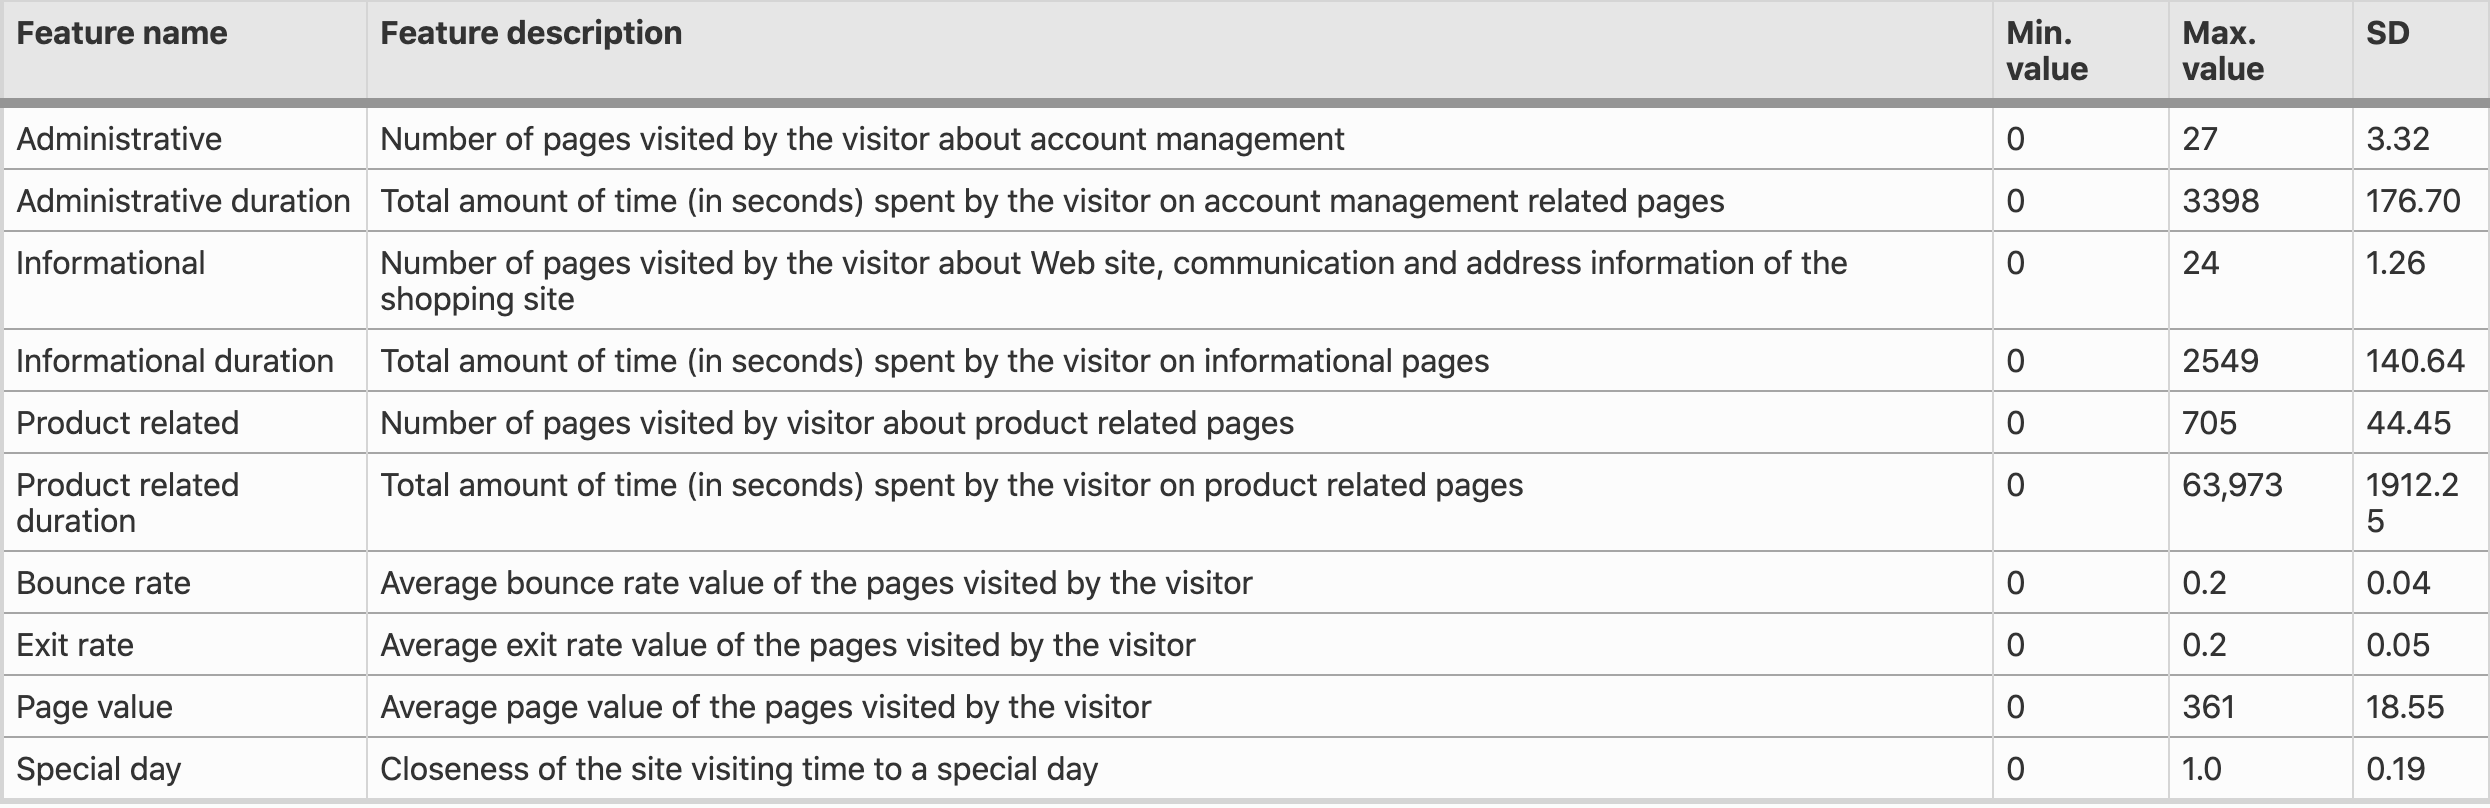
    
    <br>
    - Categorical Feature descriptions
    
    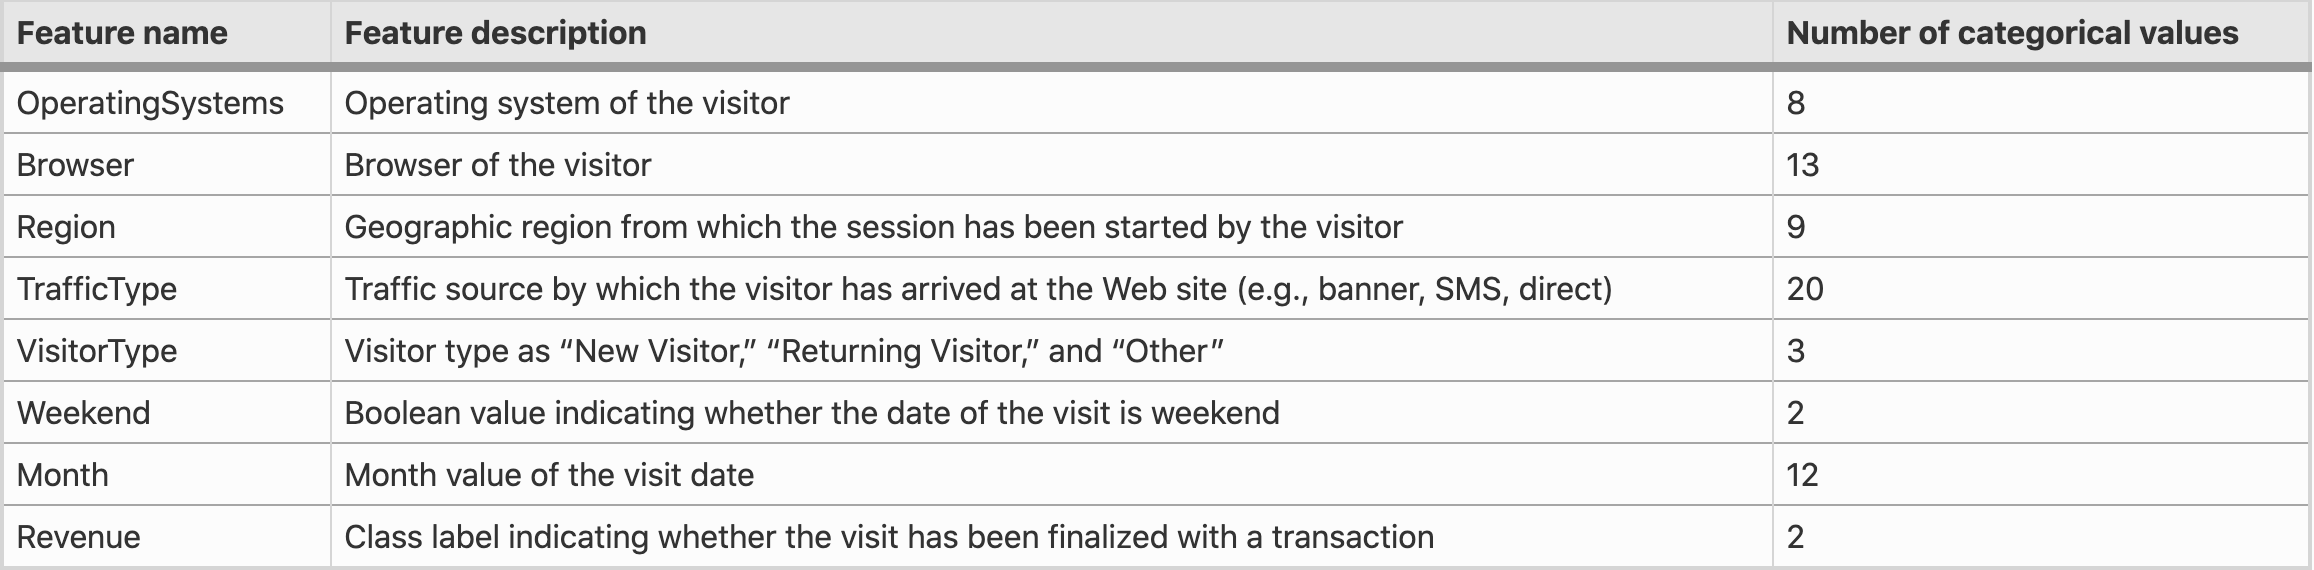
    

## Define the Problem (10%)

## Data Preprocessing and Vizualization (25%)

The following cell contains functions that we will use for data preprocessing

In [49]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(random_data.index(outlier))
    return anomalies



# Functions to find outliers       
def replace_outliers_mean(column):
    temp = []
    for i in df[column]:
        temp.append(i)
    mean = np.mean(temp) 
    outlier_index = find_anomalies(temp)
    for i in outlier_index:
        df[column][i] = mean
        
        
# Functions to find outliers of zero inflated data
# Removes all rows with zeros, finds outliers, then places zero rows back into dataset
def replace0_outliers_mean(column):
    temp = []
    for i in df[column]:
        if i != 0:
            temp.append(i)
    meanTemp = np.mean(temp) 
    outlier_index = find_anomalies(temp)
    for i in outlier_index:
        df[column][i] = meanTemp


The following cell contains functions that we will use to visualize out preprocessed data.

In [50]:
# Function creates a scatter plot to show relationship between Page Value and a given column (taken as input)
def show_scatter(column):
    plt.scatter(df[column],df['PageValues'])
    plt.xlabel(column)
    plt.ylabel("Page Value")
    plt.show() 

Data Preprocessing:

1) We read in the dataset.

2) We check the numerical features to find the columns that contain zero-inflated data (we are considering this to be near or above 50% of the data in that column). We then, accordingly, use the functions that we created above to detect outliers and replace them with the means of their columns.

3) For the next step in preprocessing the data, we use the pandas function get_dummies() to convert all categorical feature columns with dummy variables. We use dummy variables instead of mapping them to numeerical values because numerical values would imply that our categorical variables contain some sort of significance in their order, while dummy variables ensure that there is no siginificance placed on their order. To protect from creating issues with colliniearity, which is a downfall that can come with using dummy variabes, we dropped the first created variable column from each categorical feature.

There are no missing values in our data.

In [51]:
#import dataset
df = pd.read_csv("online_shoppers_intention.csv")


#Searching for 0-inflated columns by finding percent 0s in each column
columns = []
for i in df:
    columns.append(i)
    
for c in columns:
    count = 0
    for i in range(len(df[c])):
        if df[c][i] == 0:
            count += 1
                    
#0 inflated replacing outliers
replace0_outliers_mean('Administrative')
replace0_outliers_mean('Administrative_Duration')
replace0_outliers_mean('Informational')
replace0_outliers_mean('Informational_Duration')
replace0_outliers_mean('BounceRates')

#other replacing outliers
replace_outliers_mean('ExitRates')
replace_outliers_mean('ProductRelated')
replace_outliers_mean('ProductRelated_Duration')


#creating dummy variables for all categorial feautres
df_dummy=pd.get_dummies(data=df,columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType',
                                         'Weekend','Revenue'],drop_first=True)
df_dummy.rename(columns={'Revenue_True':'Revenue'},inplace=True)


/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Below, we plot each feature against page value to see how correlated they are. We chose to plot them against page value because page value is directly correlated to revenue, our target feature.

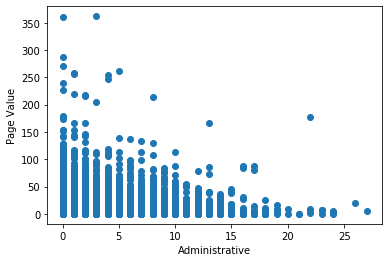

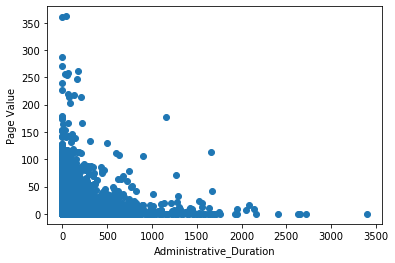

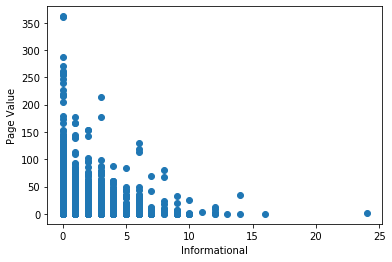

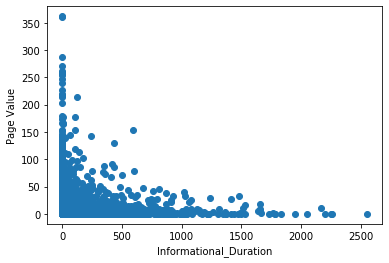

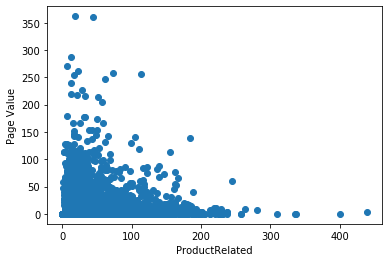

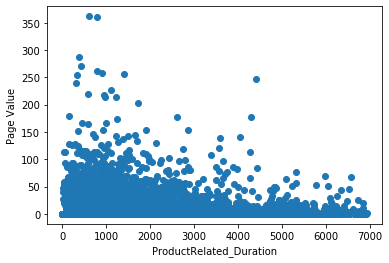

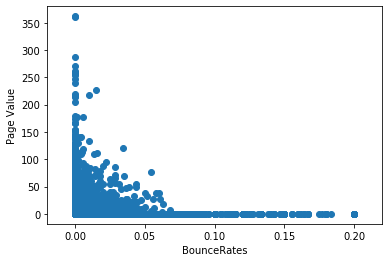

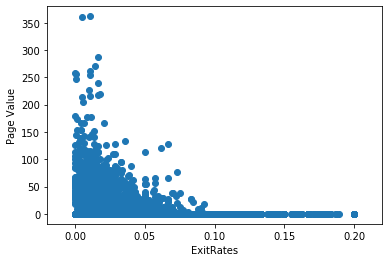

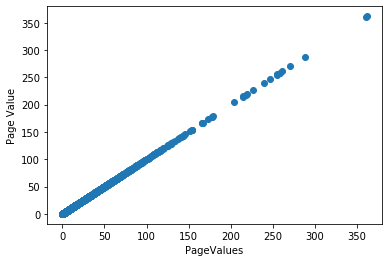

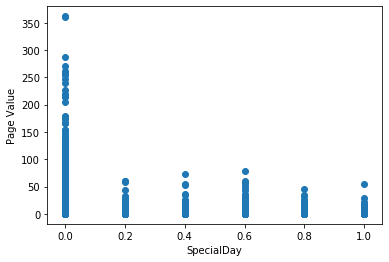

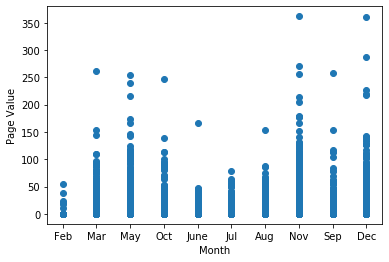

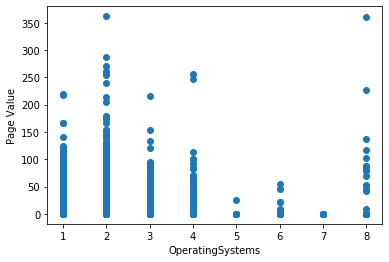

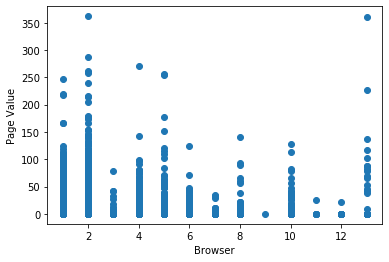

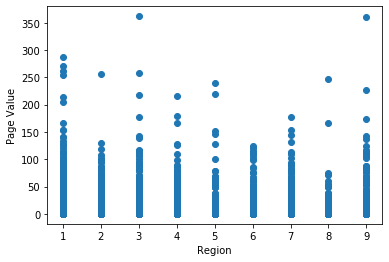

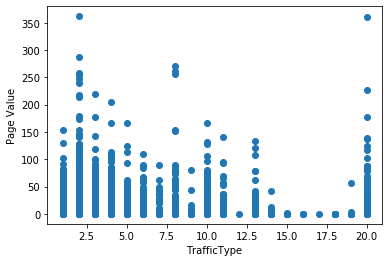

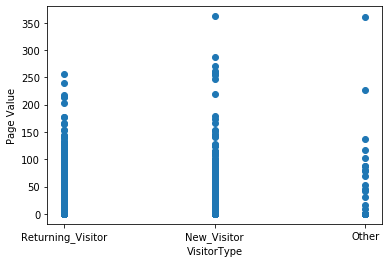

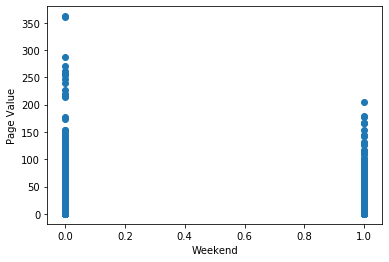

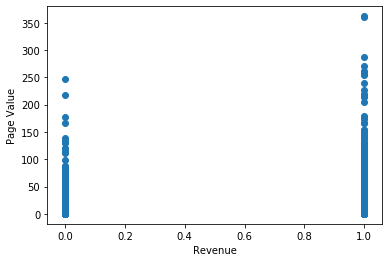

In [52]:
for c in df:
    show_scatter(c)

## Model Construction (45%)

To begin constructing our model, we have chosen a list of classification models that we think may be effective for our data. We explore the following models: KNN, SVC, Decision Tree, Random Forest, AdaBoost, Naive Bayes, LDA, and Logisitic Regression. For each of these models we use Kfold cross validation with 5 spltis to find the AUC and accuracy. We then observe our results.

In [ ]:
#train-test split
X = df_dummy.iloc[:, :-1]
y = df_dummy.Revenue
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#models to explore
clfs = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "RBF SVM": SVC(gamma='auto'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=2, n_estimators=10, max_features=1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression" : LogisticRegression(solver ='lbfgs')}

keys = list(clfs.keys())
values = list(clfs.values())
    

#Using K-Fold Cross Validation to find the best accuracies of each model  
mean_aucs = []
mean_accuracies = []
model_names = []

for v in values:
    
    kfold = model_selection.KFold(n_splits=5,shuffle=True,random_state=0)
    auc = model_selection.cross_val_score(v,X,y,cv=kfold,scoring='roc_auc')
    accuracy = model_selection.cross_val_score(v,X,y,cv=kfold,scoring='accuracy')
    index = values.index(v)
    mean_auc = auc.mean() * 100
    mean_accuracy = accuracy.mean() * 100
    mean_aucs.append(mean_auc)
    mean_accuracies.append(mean_accuracy)
    model_name = keys[index]
    model_names.append(model_name)
   
mean_models = list(zip(mean_aucs,mean_accuracies, model_names))
mean_models.sort()
print("AUC/Accuracy/Model Name")
mean_models


Due to the high AUCs and accuraracies, we have chosen to use Decision Tree, AdaBoost, and LDA.


Using these three models, we will now play around with several different paramaters that are either colinear or have a low correlation to revenue to see if we can improve the outcome of our model without overfitting to our current data.

In [ ]:
    
#drop ones that are not correlated to see if AUC gets higher
df_copy = df
df_copy = df_copy.drop(['Region'], axis = 1)

df_dummy = pd.get_dummies(data=df_copy,columns=['Month','OperatingSystems','Browser','TrafficType','VisitorType',
                                         'Weekend','Revenue'],drop_first=True)
df_dummy.rename(columns={'Revenue_True':'Revenue'},inplace=True)


Here, we are plotting ROC curves the different models that we have chosen.

In [ ]:
#function used to classify Xs & ys for each model
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf_chosen = {"Logistic Regression" : LogisticRegression(solver ='lbfgs'),
             "AdaBoost": AdaBoostClassifier(),
             "Decision Tree": DecisionTreeClassifier(max_depth=5),
             "LDA": LinearDiscriminantAnalysis()}

def plot_ROC(X_test,y_test,clf):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs) 
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs) 
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('ROC Curve')
    # show the plot
    pyplot.show() 
    
def plot_confusionMatrix(y_test,y_pred):
    cm=confusion_matrix(y_test,y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (9,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.show()
def classify(X_train,X_test,y_train,y_test):
    AUCS = []
    accuracies = []
    i=0
    for c in clf_chosen.values():
        c.fit(X_train,y_train)
        y_pred = c.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(list(clf_chosen.keys())[i])
        print("Accuracy:",accuracy)
        print("AUC:",auc)
        plot_ROC(X_test,y_test,c)
        print('\n')
        plot_confusionMatrix(y_test,y_pred)
        #AIC = calc_AIC(y_pred,y_test,X_test.shape[1])
        #print("AIC SCORE:",AIC)
        print('\n')
        i+=1
        #AUCS.append(auc)
        #accuracies.append(accuracy)
        

#classify using each model, prints out AUC & Accuracy        
classify(X_train,X_test,y_train,y_test)
#classify(NX_train,NX_test,Ny_train,Ny_test)


'''
#pca
pca = PCA(n_components = 2)
pca.fit(NX_train)
print(pca.explained_variance_ratio_)
'''

## Future Plans (10%)